In [128]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [129]:
# Credentials
DB_NAME = 'documentcoder'
DB_USER = 'postgres'
DB_PASS = 'save'

In [130]:
# CONNECTION IS ESTABLISHED IF NOTHING RETURNS 
conn = psycopg2.connect(dbname=DB_NAME, user=DB_USER, password=DB_PASS)

In [131]:
# Create Cursor to execute statements
cur = conn.cursor()

In [132]:
# Task at hand is to create a spreadsheet that has all the codings and all the questions 
# Plan to organize that: 
# retrieve a list of all the question id for specific policies like CCPA, GDPR, and so on 
#     To do so query: select for specific question id based on their labels: GDPR, CCPA, then store them in a dictionary
# then using that dictionary we can map coding instance answers to their associated question labels

In [133]:
cur.execute(
    "SELECT arr.item_object FROM api_coding, \
    jsonb_array_elements(categories) with ordinality arr(item_object, position)")

In [134]:
api_codings = cur.fetchall()

In [135]:
codings_dict = {}
questions_dict = {}

for coding in api_codings: 
    #print('label: ', coding[0]['label'])
    label = coding[0]['label']
    ids = []
    for question in coding[0]['questions']:
        id = question['id']
        questions_dict[id] = question['description']
        ids.append(id)
        
    codings_dict[label] = ids
    
# print(codings_dict)
# print(questions_dict)

In [136]:
def store_answer_freq(coding_instances):
    counter = defaultdict(int)
    for instance in coding_instances: 
        # checks to see if answer object has content or not, the second condition checks for empty objects 
        if (instance[0] is not None) and (bool(instance[0]) != False):
            counter[next(iter(instance[0]))] += 1
    
    #print(counter)
    return counter

In [137]:
def store_answer_conf(coding_instances):
    counter = defaultdict(int)
    for instance in coding_instances: 
        if (instance[1] is not None):
            counter[instance[1]] += 1
    
    #print(counter)
    return counter

In [138]:
def calc_median(conf_dict): 
    return np.median(list(conf_dict.values()))

In [139]:
def calc_median_time(timing_arr): 
#     print(sorted(timing_arr))
#     print(np.median(np.array(timing_arr)))
#     print('--------------')
    return np.median(np.array(timing_arr))

In [140]:
def did_mediate(response_arr): 
    none_filter = [item for item in response_arr if item[0]]

    if len(none_filter) == 0:
        return False
    else: 
        return True

In [141]:
# [0] = no
# [1] = yes
# [.] = n/a

answer_mappings = {}

for coding, q_ids in codings_dict.items(): 
    coding_answers_list = []
    for q_id in q_ids: 
        cur.execute("""
            SELECT coding_values->%s->'values', coding_values->%s->'confidence'
            FROM api_codinginstance
            WHERE coder_email != 'davidbstein@gmail.com';
            """,[q_id,q_id,])
        
        query_res = cur.fetchall()
        freqs = store_answer_freq(query_res)
        confs = store_answer_conf(query_res)
        median_conf = calc_median(confs)
        
        cur.execute("""
            SELECT question_timings->%s->'total_focus', question_timings->%s->'total_blur'
            FROM api_timingsession 
            WHERE coder_email != 'davidbstein@gmail.com';
            """,[q_id,q_id,])
        
        query_res = cur.fetchall()
        
        focus_res = [timing_inst[0] for timing_inst in query_res if timing_inst[0]]
        blur_res = [timing_inst[1] for timing_inst in query_res if timing_inst[1]]
        
        median_focus = calc_median_time(focus_res)
        median_blur = calc_median_time(blur_res)
        
        cur.execute("""
            SELECT coding_values->%s->'values'
            FROM api_codinginstance
            WHERE coder_email = 'florencia.m.wurgler@gmail.com'; 
        """,[q_id,])
        
        query_res = cur.fetchall()
        fmw = did_mediate(query_res)
        
        answer_stats = {'q_id': q_id,
                        'q_text': questions_dict[q_id],
                       'answer_freq': freqs,
                       'conf_freq': confs,
                       'median_conf': median_conf,
                       'median_focus': median_focus,
                       'median_blur': median_blur,
                       'FMW': fmw}
        
        coding_answers_list.append(answer_stats)
    
    answer_mappings[coding] = coding_answers_list
        

In [142]:
# cur.close()
# conn.close()

In [143]:
print(answer_mappings)

{'CCPA': [{'q_id': 'v72.1_2020.1', 'q_text': 'Is the CCPA section in a separate link (as opposed to in the same privacy policy?)', 'answer_freq': defaultdict(<class 'int'>, {'1': 10, '0': 7, '.': 6}), 'conf_freq': defaultdict(<class 'int'>, {'5': 15, '3': 2, '4': 3}), 'median_conf': 3.0, 'median_focus': 28680.0, 'median_blur': 18158.0, 'FMW': True}, {'q_id': 'v72.2_2020.1', 'q_text': 'Does PP states firms\' CCPA policy only applies to California residents? (for example,  Tinder\'s  states that "This California section supplements the Privacy Policy and applies solely to California consumers (excluding our personnel). The Table below describes how we process California consumers’ personal information (excluding our personnel), based on definitions laid out in the California Consumer Privacy Act ("CCPA")." ', 'answer_freq': defaultdict(<class 'int'>, {'0': 9, '1': 8, '.': 6}), 'conf_freq': defaultdict(<class 'int'>, {'4': 6, '5': 8, '2': 2, '3': 3}), 'median_conf': 4.5, 'median_focus': 1

In [144]:
CCPA = answer_mappings['CCPA']
notice = answer_mappings['Notice']
sharing = answer_mappings['Sharing']
user_control = answer_mappings['User Control']
security = answer_mappings['Security']
data_practices = answer_mappings['Data Practices']
enforcement = answer_mappings['Enforcement']
privacy_by_design = answer_mappings['Privacy By Design']
contract = answer_mappings['Contract']
GDPR = answer_mappings['GDPR']
covid = answer_mappings['COVID']
notice_of_contract = answer_mappings['[Skip me!] Notice of Contract']

In [145]:
def create_coding_df(mapping):
    df_base = {'question_id': [], 'question_text': [], '0': [], '1': [], '2': [], 'n/a': [], 'DND': [], 
               'confidence_0': [], 'confidence_1': [], 'confidence_2': [], 'confidence_3': [], 
               'confidence_4': [], 'confidence_5': [], 'median_confidence': [], 
               'median_focus': [], 'median_blur': [], 'FMW': []}
    
    df = pd.DataFrame(data=df_base)
    
    for i in range(0, len(mapping)): 
        row = {'question_id': mapping[i]['q_id'], 'question_text': mapping[i]['q_text'], 
               '0': mapping[i]['answer_freq']['0'], '1': mapping[i]['answer_freq']['1'], 
               '2': mapping[i]['answer_freq']['2'], 'n/a': mapping[i]['answer_freq']['.'], 
               'DND': mapping[i]['answer_freq']['DND'], 'confidence_0': mapping[i]['conf_freq']['0'], 
               'confidence_1': mapping[i]['conf_freq']['1'], 'confidence_2': mapping[i]['conf_freq']['2'], 
               'confidence_3': mapping[i]['conf_freq']['3'], 'confidence_4': mapping[i]['conf_freq']['4'], 
               'confidence_5': mapping[i]['conf_freq']['5'], 'median_confidence': mapping[i]['median_conf'], 
               'median_focus': mapping[i]['median_focus'], 'median_blur': mapping[i]['median_blur'], 
               'FMW': mapping[i]['FMW']}
    
        df = df.append(row, ignore_index = True)
    
    return df

In [146]:
CCPA_df = create_coding_df(CCPA)
notice_df = create_coding_df(notice)
sharing_df = create_coding_df(sharing)
user_control_df = create_coding_df(user_control)
security_df = create_coding_df(security)
data_practices_df = create_coding_df(data_practices)
enforcement_df = create_coding_df(enforcement)
privacy_by_design_df = create_coding_df(privacy_by_design)
contract_df = create_coding_df(contract)
GDPR_df = create_coding_df(GDPR)
covid_df = create_coding_df(covid)
notice_of_contract_df = create_coding_df(notice_of_contract)

In [147]:
with pd.ExcelWriter('coding_stats.xlsx') as writer:  
    CCPA_df.to_excel(writer, sheet_name='CCPA')
    notice_df.to_excel(writer, sheet_name='Notice')
    sharing_df.to_excel(writer, sheet_name='Sharing')
    user_control_df.to_excel(writer, sheet_name='User Control')
    security_df.to_excel(writer, sheet_name='Security')
    data_practices_df.to_excel(writer, sheet_name='Data Practices')
    enforcement_df.to_excel(writer, sheet_name='Enforcement')
    privacy_by_design_df.to_excel(writer, sheet_name='Privacy by Design')
    contract_df.to_excel(writer, sheet_name='Contract')
    GDPR_df.to_excel(writer, sheet_name='GDPR')
    covid_df.to_excel(writer, sheet_name='COVID')
    notice_of_contract_df.to_excel(writer, sheet_name='Notice of Contract')

In [148]:
CCPA_df

,question_id,question_text,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,median_focus,median_blur,FMW
0,v72.1_2020.1,Is the CCPA section in a separate link (as opp...,7.0,10.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,3.0,15.0,3.0,28680.0,18158.0,1.0
1,v72.2_2020.1,Does PP states firms' CCPA policy only applies...,9.0,8.0,0.0,6.0,0.0,0.0,0.0,2.0,3.0,6.0,8.0,4.5,17838.0,39932.0,1.0
2,v73_2020.1,Directs CA Residents to that section when desc...,11.0,5.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,11.0,5.0,5.0,10092.5,26947.0,0.0
3,v74_2020.1,Personal Information Request: Offers CA reside...,7.0,11.0,0.0,5.0,0.0,0.0,0.0,4.0,1.0,6.0,8.0,5.0,27377.5,37783.0,1.0
4,v75_2020.1,Offers California residents a direct link via ...,3.0,6.0,7.0,7.0,0.0,0.0,0.0,1.0,6.0,7.0,6.0,6.0,37242.0,33846.0,1.0
5,v76_2020.1,Data requests are explicitly free of charge?,10.0,3.0,0.0,10.0,0.0,0.0,0.0,2.0,5.0,9.0,4.0,4.5,20716.5,41245.5,1.0
6,v77_2020,Does the PP list the categories of personal in...,6.0,8.0,0.0,8.0,0.0,0.0,0.0,2.0,3.0,8.0,5.0,4.0,32596.5,34284.0,0.0
7,v78_2020.1,PP identifies at least two methods for submitt...,3.0,2.0,4.0,5.0,0.0,0.0,1.0,0.0,3.0,10.0,5.0,4.0,45705.0,24216.0,1.0
8,v72_2020.1,Has California Privacy Rights Section that exp...,5.0,6.0,8.0,4.0,0.0,0.0,0.0,1.0,7.0,10.0,2.0,4.5,88428.0,12807.0,1.0
9,v80_2020.1,Firm offers the right of opt-out of selling pe...,10.0,0.0,6.0,7.0,0.0,0.0,1.0,1.0,1.0,12.0,4.0,1.0,29858.0,14731.5,1.0


In [149]:
notice_df

,question_id,question_text,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,median_focus,median_blur,FMW
0,v3_2020,Is there layered notice or short notice? (i.e....,22.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,14.0,2.0,2.0,18891.5,28377.0,1.0
1,v10.1_2020,"Does the company have a cookie policy? (note ""...",3.0,21.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,14.0,2.5,33206.0,28593.0,1.0
2,v10.2_2020.1,Does the company explicitly state they use tra...,4.0,20.0,0.0,0.0,1.0,0.0,1.0,2.0,7.0,8.0,2.0,2.0,51076.5,103076.5,1.0
3,v11.1_2020,Biometric Information Collected and Stored? (e...,13.0,6.0,0.0,0.0,5.0,0.0,1.0,0.0,2.0,11.0,5.0,3.5,15526.0,30343.0,1.0
4,v12_2020.1,Company commits that PII will be used internal...,24.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,5.0,7.0,1.0,3.0,86314.0,76539.5,1.0
5,v13_2020.1,Company commits to use PII (personally identif...,23.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,8.0,8.0,0.0,8.0,26777.0,97938.0,1.0
6,v17_2020,Third party tracking: site allows third partie...,1.0,19.0,0.0,0.0,4.0,0.0,1.0,1.0,2.0,6.0,8.0,2.0,60189.5,67026.0,1.0
7,v18_2020,PP identifies third party recipients of shared...,4.0,2.0,0.0,0.0,19.0,0.0,0.0,4.0,2.0,10.0,3.0,3.5,42509.0,71669.0,1.0
8,v19_2020,"PP defines words such as ""affiliates"" or ""thir...",24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,13.0,3.0,2.5,8289.5,50652.0,1.0
9,v32_2020,PP has a Change of Terms (COT) provision that ...,2.0,23.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,5.0,15.0,3.5,34998.5,30699.0,1.0


In [150]:
sharing_df

,question_id,question_text,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,median_focus,median_blur,FMW
0,v20_2020.1,Are affiliates and/or subsidiaries (specifical...,7.0,9.0,0.0,0.0,8.0,0.0,0.0,1.0,5.0,11.0,3.0,4.0,46694.0,76975.0,1.0
1,v21_2020.1,Are contractors/service providers (under CCPA)...,4.0,10.0,0.0,0.0,9.0,0.0,1.0,1.0,4.0,9.0,2.0,2.0,48947.0,81104.0,1.0
2,v22_2020.1,Are third parties bound by the same privacy po...,14.0,4.0,0.0,0.0,4.0,0.0,1.0,2.0,6.0,6.0,3.0,3.0,37874.0,55393.0,1.0
3,v27_2020.1,Entity performs due diligence to ensure legiti...,3.0,0.0,0.0,0.0,20.0,0.0,0.0,1.0,5.0,12.0,0.0,5.0,9531.0,19866.5,1.0
4,v28_2020,Entity has contract with 3rd parties (excludin...,4.0,5.0,0.0,1.0,13.0,0.0,1.0,2.0,6.0,9.0,0.0,4.0,30090.0,32586.0,1.0
5,v29_2020,PP provides links to relevant 3rd parties' PP'...,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.0,2.0,2.0,12385.0,14612.0,1.0
6,v31_2020,What is consent mechanism for sharing/selling ...,15.0,4.0,1.0,3.0,0.0,0.0,0.0,5.0,4.0,9.0,0.0,5.0,76196.0,42911.0,1.0


In [151]:
user_control_df

,question_id,question_text,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,median_focus,median_blur,FMW
0,v37_2020,Can users can adjust privacy settings? [Doubl...,7.0,16.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,10.0,5.0,1.0,47454.5,43311.5,1.0
1,v38_2020.1,Are users allowed to access and correct/update...,3.0,5.0,15.0,0.0,0.0,0.0,1.0,0.0,1.0,11.0,6.0,3.5,84995.0,55131.5,1.0
2,v37.2_2020.1,Can the user request that incorrect data be ei...,2.0,0.0,15.0,0.0,6.0,0.0,1.0,1.0,4.0,10.0,2.0,2.0,30899.0,55803.0,1.0
3,v39_2020,Can user request that information be deleted o...,3.0,17.0,2.0,0.0,0.0,0.0,3.0,2.0,2.0,9.0,1.0,2.0,57329.0,38139.0,1.0
4,v40_2020.1,Ownership Rights of User Information Provided ...,3.0,5.0,0.0,0.0,14.0,0.0,0.0,6.0,6.0,4.0,2.0,5.0,74638.0,96770.0,0.0
5,v47_2020.1,What happens to data if entity ceases to exist...,8.0,6.0,0.0,0.0,9.0,0.0,1.0,0.0,1.0,15.0,2.0,1.5,26246.0,32870.0,1.0
6,v49_2020,"If company is sold or goes bankrupt, user is g...",21.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,13.0,1.0,2.0,11975.5,15950.0,1.0
7,v51_2020,"If user quits site, what happens to personal d...",2.0,4.0,4.0,0.0,13.0,0.0,1.0,3.0,3.0,10.0,2.0,3.0,26737.0,59483.0,1.0


In [152]:
security_df 

,question_id,question_text,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,median_focus,median_blur,FMW
0,v41_2020,PP/TOU guarantees data accuracy (must say the ...,20.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,8.0,5.0,11651.0,13406.0,1.0
1,v42_2020,PP specifies reasonable procedures in place to...,17.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,12.0,1.0,2.5,16598.0,36886.5,1.0
2,v43_2020,PP reserves right to disclose protected inform...,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,9.5,39001.0,43567.0,1.0
3,v44_2020,PP reserves right to disclose protected inform...,0.0,22.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,13.0,5.0,17755.5,17190.0,0.0
4,v45_2020,Users will be given notice of government reque...,18.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,12.0,2.0,2.5,19024.0,30012.0,1.0
5,v46_2020,User will be notified of data breach?,22.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.0,3.0,3.0,7048.0,37116.0,1.0
6,v53_2020,PP describes substantive privacy and security ...,14.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,11.0,3.0,3.0,44781.0,102346.5,1.0
7,v54_2020,PP specifically identifies means of technologi...,6.0,16.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,7.0,6.0,4.5,25808.0,30962.5,1.0


In [153]:
data_practices_df 

,question_id,question_text,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,median_focus,median_blur,FMW
0,v52_2020,Does company have a procedure for safely dispo...,18.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,11.0,1.0,3.5,10508.0,38753.5,1.0


In [154]:
enforcement_df 

,question_id,question_text,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,median_focus,median_blur,FMW
0,v55_2020,PP provides means by which user can contact si...,0.0,20.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,7.0,8.0,2.0,61001.5,40778.5,1.0
1,v56_2020,"PP has forum selection clause? If so, which fo...",7.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,11.0,4.0,45879.0,55438.0,1.0
2,v57_2020,"PP has choice of law clause? If so, which law...",1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,9.0,17238.5,27304.0,1.0
3,v58_2020,PP has arbitration clause? (Look in TOU as well),12.0,9.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,10.0,4.0,3.5,29293.0,12646.5,1.0
4,v59_2020,PP has class action waiver? (Look in TOU as w...,13.0,9.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,13.0,3.0,2.0,10127.5,8517.5,1.0
5,v60_2020,PP disclaims liability for failure of security...,7.0,15.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,8.0,3.0,3.5,62181.0,82629.0,1.0
6,v61_2020,PP provides link to FTC's Consumer Complaint F...,21.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,7.0,9.5,8220.0,16360.0,1.0
7,v62_2020.1,What privacy seal/certification/industry overs...,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,12.0,0.0,8.5,12958.0,46670.5,1.0


In [155]:
privacy_by_design_df 

,question_id,question_text,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,median_focus,median_blur,FMW
0,v63_2020,PP requires periodic compliance review of stru...,15.0,7.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,11.0,1.0,2.0,13620.5,58860.5,1.0
1,v64_2020,PP contains self-reporting measures in case of...,22.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,13.0,0.0,4.0,7208.0,19396.0,1.0


In [156]:
contract_df 

,question_id,question_text,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,median_focus,median_blur,FMW
0,PP_in_TOU,Is the PP incorporated by reference in the TOU?,2.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,13.0,9.5,24743.5,21220.0,1.0


In [157]:
GDPR_df 

,question_id,question_text,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,median_focus,median_blur,FMW
0,v71_2020.1,PP states that it is GDPR compliant or include...,13.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,10.0,9.0,9212.5,12362.0,1.0
1,v80.2_2020.1,Does PP state it complies with EU-US Privacy S...,17.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,12.0,3.0,3.0,8364.0,5559.0,1.0
2,v80.3_2020.1,Does PP state that GDPR terms apply only and e...,6.0,3.0,0.0,13.0,0.0,0.0,1.0,1.0,1.0,8.0,7.0,1.0,11194.0,25639.0,1.0
3,v81_2020,Can users object to processing or automated de...,3.0,4.0,0.0,10.0,5.0,0.0,0.0,2.0,7.0,8.0,1.0,4.5,21707.0,36993.5,1.0
4,v82_2020,"If firm engages in automated decision making, ...",2.0,2.0,0.0,14.0,4.0,0.0,1.0,3.0,6.0,8.0,1.0,3.0,9658.0,33430.0,1.0


In [158]:
covid_df 

,question_id,question_text,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,median_focus,median_blur,FMW
0,v83_2020,Does the PP include any terms related to conta...,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,6.0,9.0,8041.5,9404.0,1.0


In [159]:
notice_of_contract_df

,question_id,question_text,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,median_focus,median_blur,FMW
0,v2_2020_txt,Users are asked to manifest consent to PP when...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9980.0,NaN,0.0
1,v0_2020.1,"For potential registrants (i.e., when you are ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4018.0,NaN,0.0
2,v1_2020,Privacy Policy (PP) is accessible through a di...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
3,v2.1_2020,Are users asked to manifest unambiguous consen...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
4,v2.2_2020,Are users asked to manifest unambiguous consen...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4870.0,NaN,0.0
5,v2.3_2020.1,Are users asked to manifest unambiguous consen...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
6,v2.4_2020.1,Are users given the option of withdrawing thei...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0


In [160]:
def plot_coding_stats(coding_df, name):
    fig = plt.figure(1)
    fig.set_figheight(5)
    fig.set_figwidth(20)

    # Adds subplot on position 1
    ax1 = fig.add_subplot(121)
    # Adds subplot on position 2
    ax2 = fig.add_subplot(122)

    ax1.set_xticklabels(coding_df['question_id'], rotation = 45)
    ax2.set_xticklabels(coding_df['question_id'], rotation = 45)

    ax1.scatter(coding_df['question_id'], coding_df['median_confidence'])
    ax1.title.set_text(name + ': Median Confidence per Question')
    ax1.legend(["Median Confidence"],loc="upper right")

    ax2.plot(coding_df['question_id'], coding_df['median_focus'])
    ax2.plot(coding_df['question_id'], coding_df['median_blur'])
    ax2.title.set_text(name + ': Median Timing per Question')
    ax2.legend(["Median Focus", "Median Blur"],loc="upper right")



    conf_timing_df = pd.DataFrame({'median confidence': coding_df['median_confidence'],
                                   'median focus': coding_df['median_focus'],
                                   'median blur': coding_df['median_blur']}
                                  ,columns=['median confidence','median focus','median blur'])


    plt.figure(2)
    corrMatrix = conf_timing_df.corr()
    sns.heatmap(corrMatrix, annot=True)
    plt.show()


/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


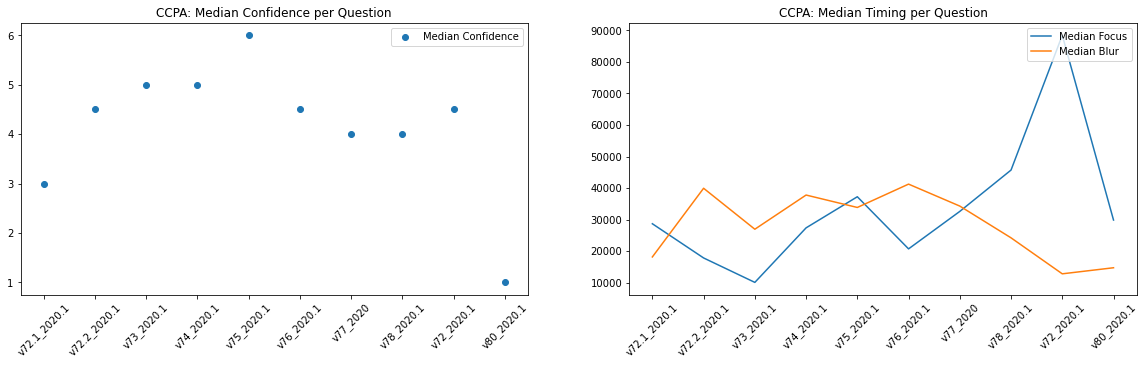

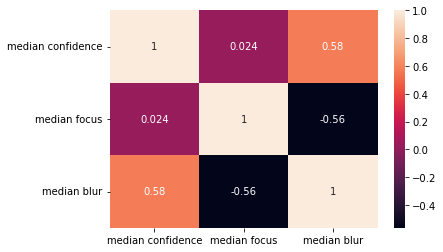

In [161]:
plot_coding_stats(CCPA_df, 'CCPA')

/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


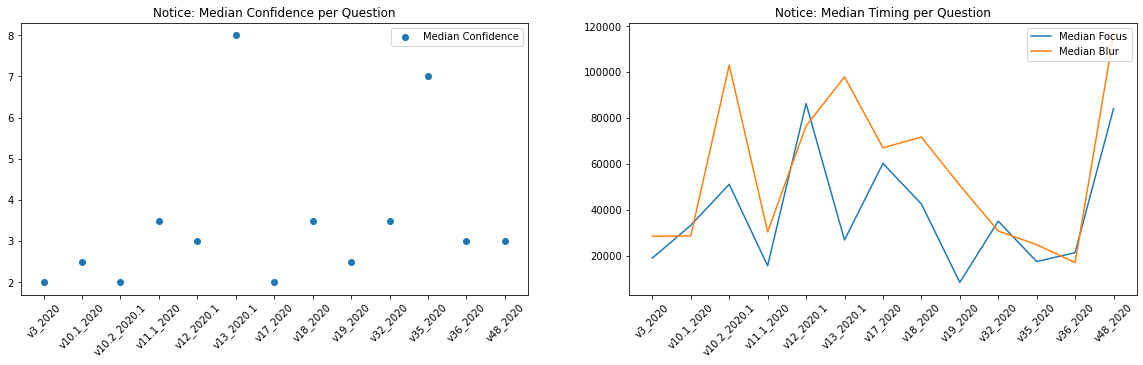

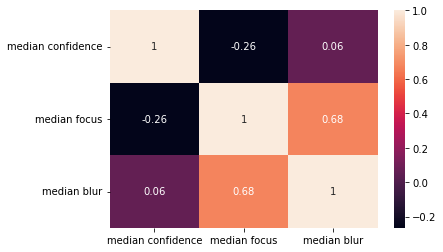

In [162]:
plot_coding_stats(notice_df, 'Notice')

/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


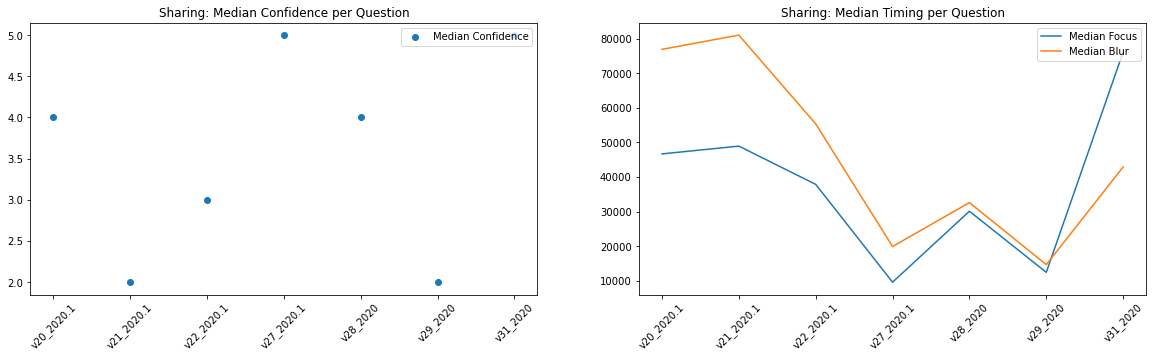

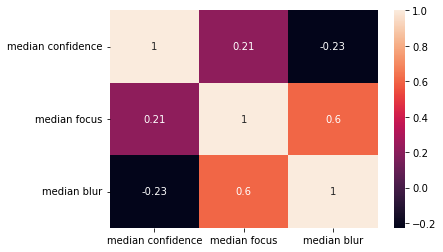

In [163]:
plot_coding_stats(sharing_df, 'Sharing')

/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


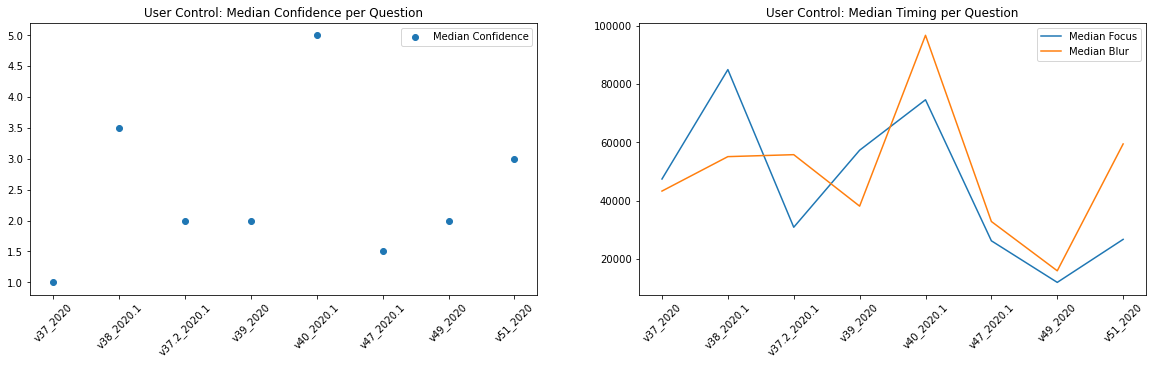

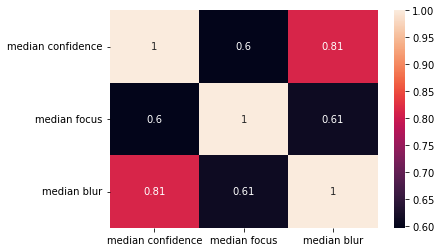

In [164]:
plot_coding_stats(user_control_df, 'User Control')

/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


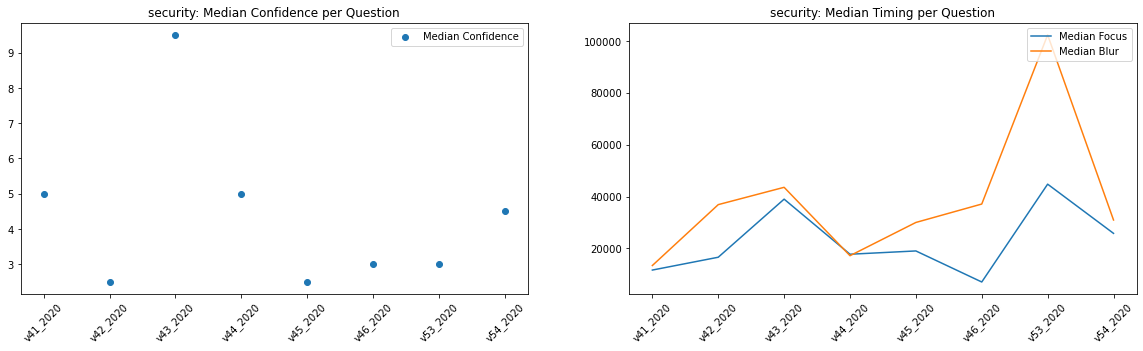

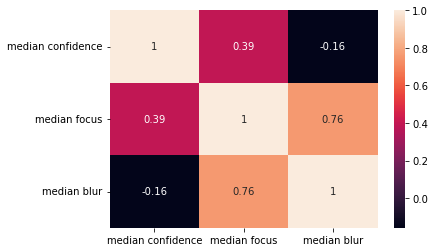

In [165]:
plot_coding_stats(security_df, 'security')

/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


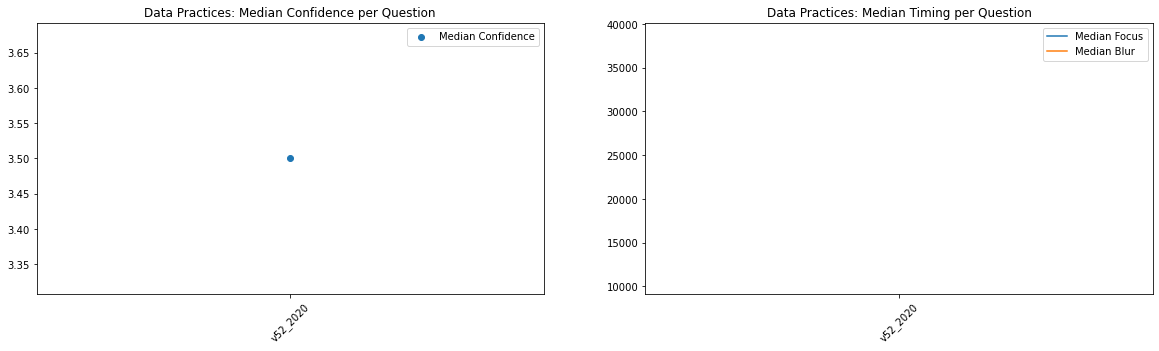

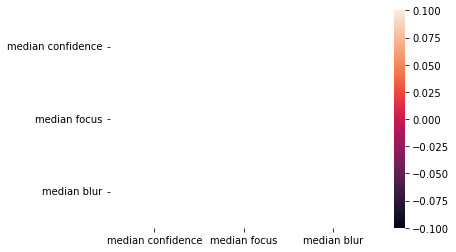

In [166]:
plot_coding_stats(data_practices_df, 'Data Practices')

/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


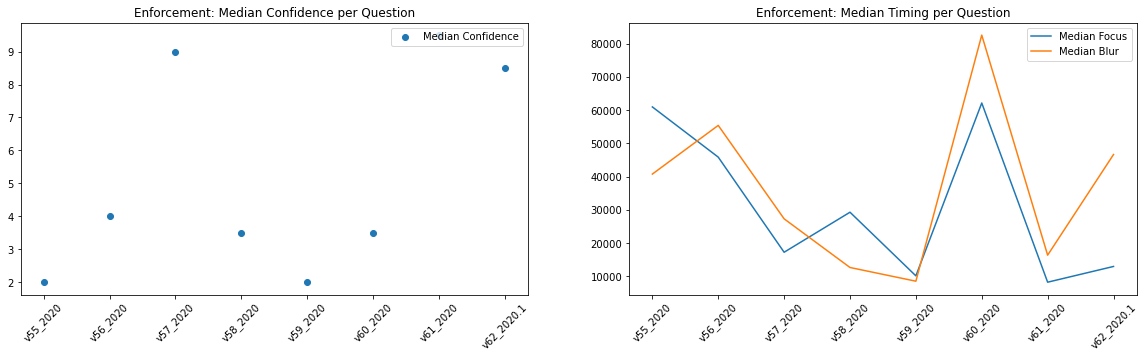

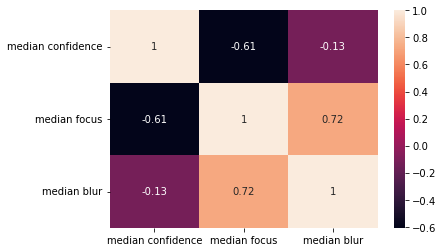

In [167]:
plot_coding_stats(enforcement_df, 'Enforcement')

/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


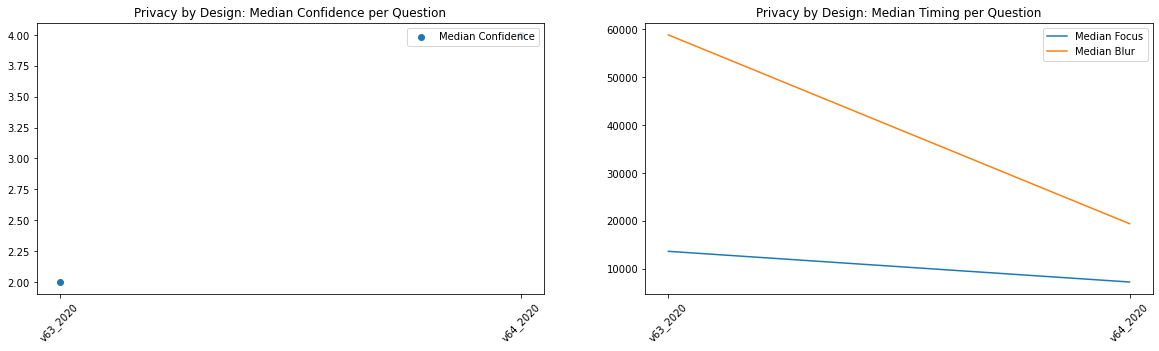

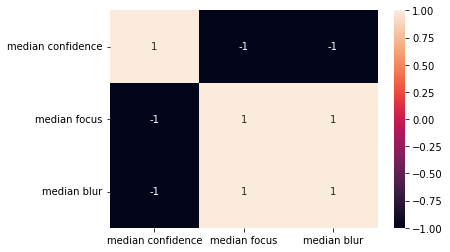

In [168]:
plot_coding_stats(privacy_by_design_df, 'Privacy by Design')

/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


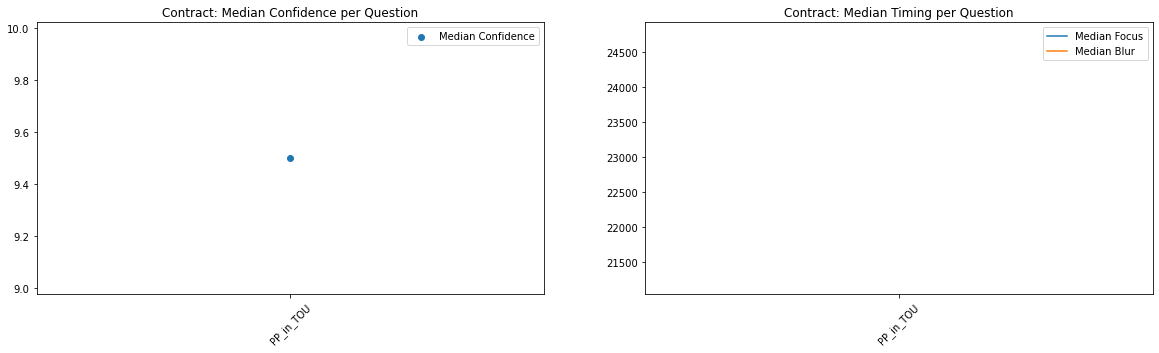

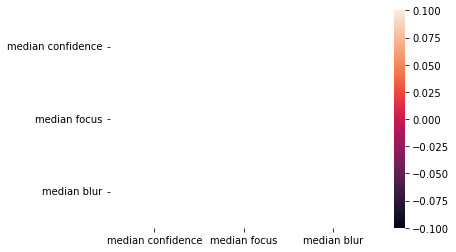

In [169]:
plot_coding_stats(contract_df, 'Contract')

/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


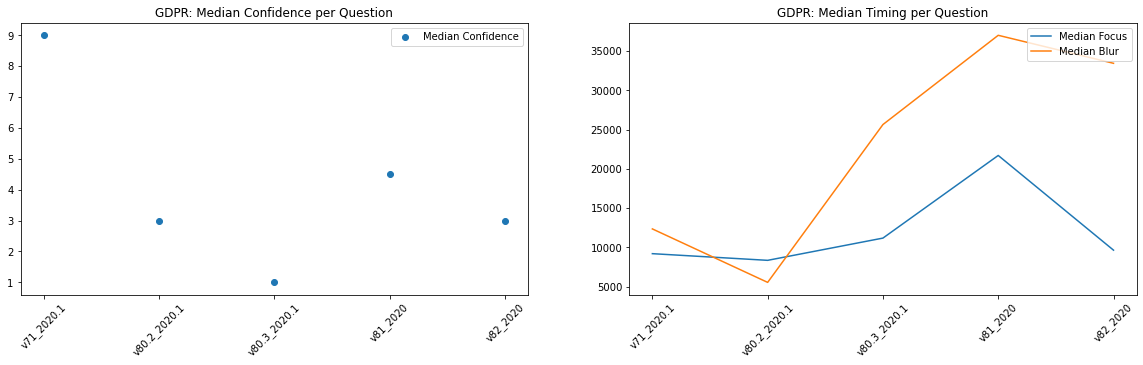

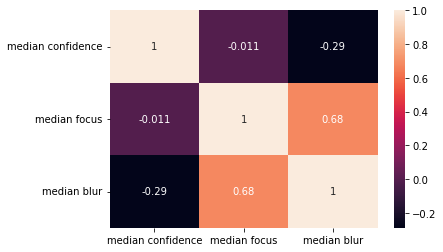

In [170]:
plot_coding_stats(GDPR_df, 'GDPR')

/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


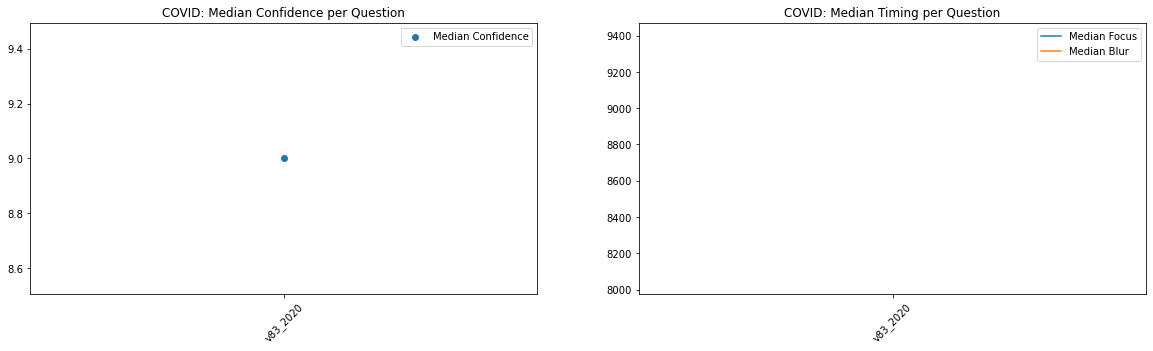

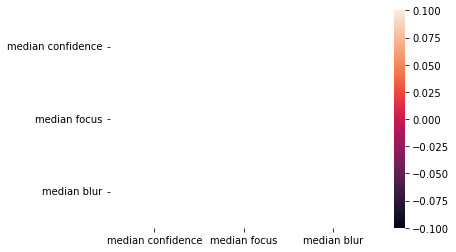

In [171]:
plot_coding_stats(covid_df, 'COVID')

/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


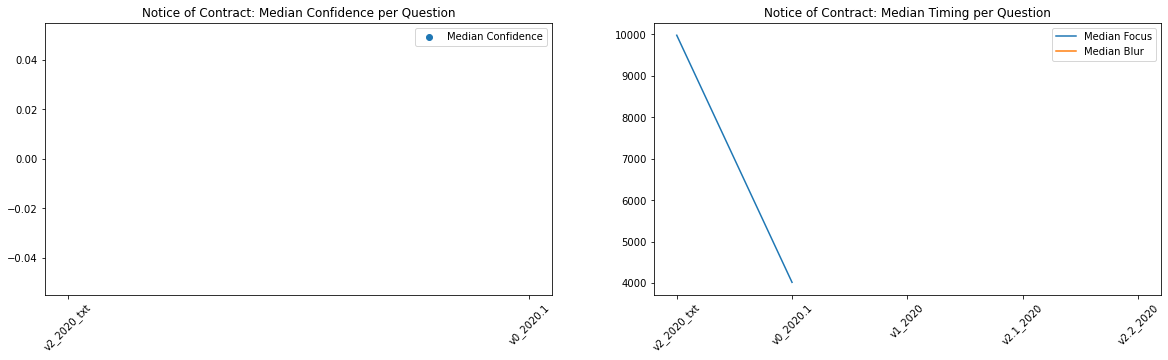

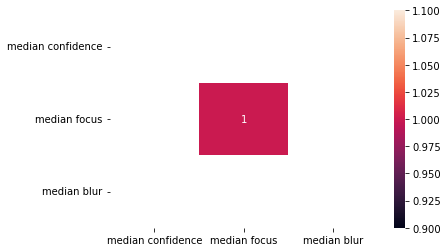

In [172]:
plot_coding_stats(notice_of_contract_df, 'Notice of Contract')